# Import

In [1]:
import pandas as pd
import re
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, Normalizer #,power_transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import roc_auc_score,classification_report, roc_curve, \
auc,accuracy_score, confusion_matrix, precision_score, log_loss, fbeta_score, recall_score


# Macros

In [2]:
DATA_FOLDER = '../../data/'
FIG_FOLDER = '../../figures/'

plt.style.use('seaborn-whitegrid')

# Utile Function

## Sklean Pipline Pandas support

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

# Prediction Model

## section data import 

In [4]:
df = pd.read_pickle(DATA_FOLDER + 'clean_pass_01p2_Ptarget_FPemp_ident_clean2.pkl')

## Medric / Score

### Model Metric - main assumtions

Main goal for business 
* Specificity / Selectivity
* try to avoid FP but also get TN right 
* the assumption that you will always find members/borrowers 
* investors are viewer and need to get investment reasons - no FP 

Prediction verfication:
* propabuilty is needed for risk assement
* the estimate must represent simmiler entropy then ground truth 
* ground truth is not balanced 
* --> cross entropy loss is taken in account to give indication

### Model Performance Overview function

In [29]:
def entropy_c(y):
    p = np.sum(y)/ len(y)
    pm = 1.-p
    return -(p*np.log(p))-(pm*np.log(pm))
                          
def entropy(y):
    return -((np.sum(y)/ len(y))*np.log(np.sum(y)/ len(y)))
                          
def rate(y):
    return np.sum(y)/ len(y)
    
def Model_Vali(m, X_train, X_test, y_train, y_test, thres=0.5, cm_print= True):
    
    
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    y_base0 = np.zeros(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
    
    print(f'train pred. rate = {rate(y_ins_pred)}' )
    print(f'train truth rate = {rate(y_train)}' )
    print(f'train truth entropy = {entropy_c(y_train)}' )
    print(f'train pred. entropy = {entropy_c(y_ins_pred)}' )
    print(f'test  pred. rate = {rate(y_outs_pred)}' )
    print(f'test  truth rate = {rate(y_test)}' )
    print(f'test  truth entropy = {entropy_c(y_test)}' )
    print(f'test  pred. entropy = {entropy_c(y_outs_pred)}' )
    
    
    print('--')
    print(f'base  recall = {recall_score(y_test, y_base)}')
    print(f'test  recall = {recall_score(y_test, y_outs_pred)}')
    print(f'train recall = {recall_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base0  precision = {precision_score(y_test, y_base0)}')
    print(f'base  precision = {precision_score(y_test, y_base)}')
    print(f'test  precision = {precision_score(y_test, y_outs_pred)}')
    print(f'train precision = {precision_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  ROC-AUC = {roc_auc_score(y_test, y_base)}')
    print(f'test  ROC-AUC = {roc_auc_score(y_test, y_outs_pred)}')
    print(f'train ROC-AUC = {roc_auc_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  accuracy = {accuracy_score(y_test, y_base)}')
    print(f'test  accuracy = {accuracy_score(y_test, y_outs_pred)}')
    print(f'train accuracy = {accuracy_score(y_train, y_ins_pred)}')
    print('--')
    print(f'base  log_loss = {log_loss(y_test, y_base)}')
    print(f'test  log_loss = {log_loss(y_test, y_outs_pred_p)}')
    print(f'train log_loss = {log_loss(y_train, y_ins_pred_p)}')
    print('--')
    print(f'base  TNR = {TNR(y_test, y_base)}')
    print(f'test  TNR = {TNR(y_test, y_outs_pred)}')
    print(f'train TNR = {TNR(y_train, y_ins_pred)}')
    

    print('--')
    cm = pd.DataFrame(confusion_matrix(y_test, y_outs_pred), 
                 index=[['actual', 'actual'], ['neg', 'pos']], 
                 columns=[['predicted', 'predicted'], ['neg', 'pos']])
    print('confusion matrix of test')
    display(cm)
    print('--')
    print(classification_report(y_test, y_outs_pred)) 
    
    base_fpr, base_tpr, base_tresh = roc_curve(y_test, y_base)
    test_fpr, test_tpr, test_tresh = roc_curve(y_test, y_outs_pred_p)
    train_fpr, train_tpr, train_tresh = roc_curve(y_train, y_ins_pred_p)
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(test_fpr, test_tpr, 'r', label = 'model-test')
    plt.plot(train_fpr, train_tpr, 'g', label = 'model-train')
    plt.plot(train_fpr, train_tresh, 'k--', label = 'thresh')
    print(len(train_tresh))
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

### Model Performance Overview function - short

In [6]:
def Model_Vali_short(m, X_train, X_test, y_train, y_test, thres=0.5, cm_print=False):
    y_ins_pred= m.predict(X_train)
    y_outs_pred= m.predict(X_test)
    y_base = np.ones(len(X_test))
    y_base0 = np.zeros(len(X_test))
    try:
        y_ins_pred_p= m.predict_proba(X_train)[:, 1]
        y_outs_pred_p= m.predict_proba(X_test)[:, 1]
        if thres!=0.5:

            y_ins_pred = [1. if e > thres else 0. for e in y_ins_pred_p]
            y_outs_pred = [1. if e > thres else 0. for e in y_outs_pred_p]
    except:
        y_ins_pred_p= y_ins_pred
        y_outs_pred_p= y_ins_pred 
        
    print(f'base1 log_loss = {log_loss(y_test, y_base)}')
    print(f'base0 log_loss = {log_loss(y_test, y_base0)}')
    print(f'test  log_loss = {log_loss(y_test, y_outs_pred_p)}')
    print(f'train log_loss = {log_loss(y_train, y_ins_pred_p)}')
    print('--')
    print(f'base1 TNR = {TNR(y_test, y_base)}')
    print(f'base0 TNR = {TNR(y_test, y_base0)}')
    print(f'test  TNR = {TNR(y_test, y_outs_pred)}')
    print(f'train TNR = {TNR(y_train, y_ins_pred)}')
    
    if cm_print:
        cm = pd.DataFrame(confusion_matrix(y_test, y_outs_pred), 
                 index=[['actual', 'actual'], ['neg', 'pos']], 
                 columns=[['predicted', 'predicted'], ['neg', 'pos']])
        
        print('confusion matrix of test')
        display(cm)
    

### Core Score function 

In [7]:
def TNR(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)[0, 0] / \
    (confusion_matrix(y_true, y_pred)[0, 1]+confusion_matrix(y_true, y_pred)[0, 0])

def ll(y_true, y_pred):
    return log_loss(y_true, y_pred)

def special_PPV(y_true, y_pred): 
    return confusion_matrix(y_true, y_pred)[1, 1] / \
    (confusion_matrix(y_true, y_pred)[0, 1]*100+confusion_matrix(y_true, y_pred)[1, 1])

## Preprocessing

### feature selection and marking

In [8]:
## All possible features
x_col_all = [
'addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']

# Target
y_col = ['target']

## Taken in account features
x_col_select = [
'dti',
'addr_state',
'term',
'annual_inc',
'loan_amnt',
'purpose',
'pub_rec',
'verification_status']
x_col_select = x_col_all
## Taken in account features
df_x = df[x_col_select]
df_y = df[y_col]

In [9]:
df.pub_rec.value_counts()

0.0    36562
1.0     2052
2.0       59
3.0       10
4.0        2
5.0        1
Name: pub_rec, dtype: int64

### Encoding - dummy cration

In [10]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
#for i in df_x_encoded.columns:
#    print(i)
df_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38686 entries, 1 to 42474
Data columns (total 79 columns):
annual_inc                             38686 non-null float64
dti                                    38686 non-null float64
emp_length                             38686 non-null float64
loan_amnt                              38686 non-null float64
open_acc                               38686 non-null float64
pub_rec                                38686 non-null float64
pub_rec_bankruptcies                   38686 non-null int64
addr_state_AL                          38686 non-null uint8
addr_state_AR                          38686 non-null uint8
addr_state_AZ                          38686 non-null uint8
addr_state_CA                          38686 non-null uint8
addr_state_CO                          38686 non-null uint8
addr_state_CT                          38686 non-null uint8
addr_state_DC                          38686 non-null uint8
addr_state_DE                          

### Toggel the truth

In [11]:
df_y = ~df_y.astype('bool')
df_y = df_y.astype('float')

### Train Test Split

,train,test,all
0.0,0.849778,0.849733,0.849765
1.0,0.150222,0.150267,0.150235


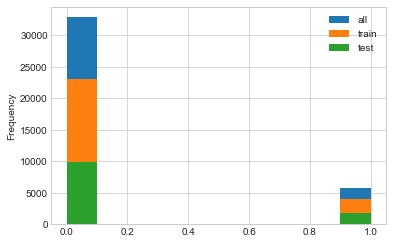

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    df_x_encoded, df_y, test_size=0.3, random_state=25, stratify=df_y)

df_y.target.plot.hist()
y_train.target.plot.hist()
y_test.target.plot.hist()
plt.legend(['all','train','test'])
tts_df = pd.DataFrame()
tts_df['train'] = (y_train.target.value_counts()/y_train.shape[0])
tts_df['test'] = (y_test.target.value_counts()/y_test.shape[0])
tts_df['all'] = (df_y.target.value_counts()/df_y.shape[0])
tts_df

### Transform and Scaling Pipline

#### simple preproc pipline

In [13]:
preprocess_pipeline_1 = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('int64'),
        )),
        ("dummy_features", make_pipeline(
            TypeSelector('uint8'),
        )),
    ]))

#### indvitual tranform pipline

In [14]:
# print the scalabels 
print(df_x_encoded.select_dtypes('float').columns)
print(df_x_encoded.select_dtypes('int64').columns)

Index(['annual_inc', 'dti', 'emp_length', 'loan_amnt', 'open_acc', 'pub_rec'], dtype='object')
Index(['pub_rec_bankruptcies'], dtype='object')


In [15]:
preprocess_pipeline_2 = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list= [
        ("sel_1",
        make_pipeline(ColumnSelector(columns=['dti' , 'loan_amnt']),
                     FunctionTransformer(lambda x:x),
                     StandardScaler()
                     )),
        ("sel_2",
        make_pipeline(ColumnSelector(columns=['annual_inc']),
                     FunctionTransformer(np.log),
                     MinMaxScaler()
                     )),
        ("sel_3",
        make_pipeline(ColumnSelector(columns=['pub_rec' , 'emp_length', 'open_acc']),
                     FunctionTransformer(lambda x:x),
                     MinMaxScaler()
                     )),
        ("bool_features", 
            make_pipeline(TypeSelector('int64'),
        )),
        ("dummy_features", 
             make_pipeline(TypeSelector('uint8'),
        )),
        ])
        )

In [16]:
t =preprocess_pipeline_2.fit_transform(X_train)
print(t.shape)
print(X_train.shape)

(27080, 79)
(27080, 79)


## Different Models

### Baseline: Logistics Regression

train pred. rate = 0.36665435745937963
train truth rate = 0.1502215657311669
train truth entropy = 0.42309322351992296
train pred. entropy = 0.6571510336513341
test  pred. rate = 0.3691194209891435
test  truth rate = 0.15026710322247114
test  truth entropy = 0.42317212569331447
test  pred. entropy = 0.6584853579056409
--
base  recall = 1.0
test  recall = 0.573394495412844
train recall = 0.5656342182890856
--
base0  precision = 0.0
base  precision = 0.15026710322247114
test  precision = 0.2334267040149393
train precision = 0.2317453922852251
--
base  ROC-AUC = 0.5
test  ROC-AUC = 0.6201995798905633
train ROC-AUC = 0.6170774950301677
--
base  accuracy = 0.15026710322247114
test  accuracy = 0.6529381354471825
train accuracy = 0.6530649926144756
--
base  log_loss = 29.349413961439407
test  log_loss = 0.6503867275177484
train log_loss = 0.651238486930639
--
base  TNR = 0.0
test  TNR = 0.6670046643682823


/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train TNR = 0.6685207717712498
--
confusion matrix of test


predicted      
                 neg   pos
actual neg      6578  3284
       pos       744  1000

--
              precision    recall  f1-score   support

         0.0       0.90      0.67      0.77      9862
         1.0       0.23      0.57      0.33      1744

    accuracy                           0.65     11606
   macro avg       0.57      0.62      0.55     11606
weighted avg       0.80      0.65      0.70     11606

6622


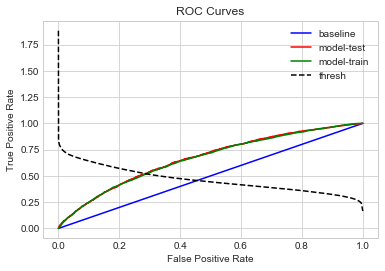

#### --- ####


In [30]:
m1_pipline=Pipeline([('pre',preprocess_pipeline_2), ('M',LogisticRegression(C=0.03, class_weight='balanced' ))])
m1_pipline.fit(X_train,y_train.values.ravel())
Model_Vali(m1_pipline, X_train, X_test, y_train.values, y_test.values, cm_print= True)
print('#### --- ####')
#m1_pipline=Pipeline([('pre',preprocess_pipeline_1), ('M',LogisticRegression(C=0.03, class_weight='balanced' ))])
#m1_pipline.fit(X_train,y_train.values.ravel())
#Model_Vali(m1_pipline, X_train, X_test, y_train, y_test, cm_print= True)

In [18]:
### Toggle the truthe
